理论来源：
    1. https://xueqiu.com/1795556147/150797873
    2. all weather strategy

In [1]:
import pandas as pd
from datetime import timedelta
from tqdm.auto import tqdm
import numpy as np
import tushare as ts
from backtest_utils import calculate_vol,calculate_cov,calculate_weight,supporting_data,four_quarters,calculate_daily_returns
from backtest_utils import calculate_performance_metrics,plot_cumulative_returns,plot_etf_returns,cal_asset,cal_smart_beta,set_random_seed
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import copy
import seaborn as sns
from datetime import datetime
tqdm.pandas()
ts.set_token('6ddb307225c1b26eaabecc4e76561c9305d5bcad10bb6b882a3e63df')
pro = ts.pro_api()

In [2]:
start_dt = '20120101'
end_dt = '20240701'
test_dt = '20130101'
vol_day = 360

In [3]:
trade_cal_SSE = pro.trade_cal(exchange='SSE', start_date=test_dt, end_date=end_dt, is_open=1)
trade_date = trade_cal_SSE['cal_date']
trade_date = trade_date[::-1]
trade_date.to_csv('trade_dates.csv', index=False)

trade_date = pd.read_csv('trade_dates.csv')
trade_date = trade_date['cal_date'].astype(str)

In [4]:
data = pd.read_csv('ret_df.csv')
data = data.sort_values(by = ['ts_code','trade_date'],ascending = True)
data['pct_chg'] = data['pct_chg'].astype(float)

data.to_csv('ret_leveraged_df.csv')

In [5]:
#无风险利率
bond_rate = pd.read_csv('bond_rate.csv')
bond_rate = bond_rate.set_index('trade_date')
bond_rate = bond_rate['close']
bond_rate.index = pd.to_datetime(bond_rate.index,format = '%Y%m%d')
bond_rate = bond_rate.reindex(trade_date, method='ffill')

In [6]:
data,leverage = calculate_vol(data,0,trade_date,vol_day)

  0%|          | 0/7 [00:00<?, ?it/s]

In [7]:
set_random_seed()

In [8]:
#主动 leverage
'''
codes = sorted(set(data['ts_code']))
dates = trade_date


leverage = {}
stock_leverage = {'000300.SH':'1.5','000905.SH':'1.5','000140.SH':'12',
                  '931080.CSI':"12",'000979.CSI':'2','MFI.WI':'1.5','850531.SI':"2"}
dates = list(set(data['trade_date']))
dates = trade_date.apply(lambda x: datetime.strptime(x, '%Y%m%d'))
for stock in codes:
    for date in dates:
        date = date.strftime('%Y%m%d')
        leverage[(stock,date)] = float(stock_leverage[stock])
'''

'\ncodes = sorted(set(data[\'ts_code\']))\ndates = trade_date\n\n\nleverage = {}\nstock_leverage = {\'000300.SH\':\'1.5\',\'000905.SH\':\'1.5\',\'000140.SH\':\'12\',\n                  \'931080.CSI\':"12",\'000979.CSI\':\'2\',\'MFI.WI\':\'1.5\',\'850531.SI\':"2"}\ndates = list(set(data[\'trade_date\']))\ndates = trade_date.apply(lambda x: datetime.strptime(x, \'%Y%m%d\'))\nfor stock in codes:\n    for date in dates:\n        date = date.strftime(\'%Y%m%d\')\n        leverage[(stock,date)] = float(stock_leverage[stock])\n'

In [9]:
# 获取计算权重以及 后续支持数据
#'510410.SH' '000140.SH'
stock_list = ['000300.SH','000905.SH','000012.SH','931080.CSI','000979.CSI','MFI.WI','850531.SI']
stocks = stock_list
_, _, date_stocks = supporting_data(data, trade_date, stocks,vol_day)
stocks_dict = {
    'stocks_1': ['000979.CSI', 'MFI.WI','850531.SI'],
    'stocks_2': ['000300.SH', '000905.SH',  'MFI.WI'],
    'stocks_3': ['000979.CSI','850531.SI', '931080.CSI', '000012.SH'],
    'stocks_4': ['000300.SH', '000905.SH', '931080.CSI', '000012.SH']}

results = four_quarters(data,trade_date,stocks_dict,vol_day)

  0%|          | 0/2790 [00:00<?, ?it/s]

  0%|          | 0/2790 [00:00<?, ?it/s]

  0%|          | 0/2790 [00:00<?, ?it/s]

  0%|          | 0/2790 [00:00<?, ?it/s]

  0%|          | 0/2790 [00:00<?, ?it/s]

In [10]:
results

{'stock_weights_1': {'000979.CSI': [0.24090712144151383,
   0.24143327058551423,
   0.24112713005290926,
   0.24125919207577648,
   0.2412708239718755,
   0.24105571159818467,
   0.25325562746776303,
   0.2558671245196593,
   0.2557364711872851,
   0.2553852067593113,
   0.25502894272263954,
   0.254891515935637,
   0.2550299112225196,
   0.25479141579106895,
   0.2547736076206106,
   0.2556524850438906,
   0.25738971784236025,
   0.2586517186776131,
   0.25840887810264396,
   0.2590689085058538,
   0.2581318804391955,
   0.26035798247014696,
   0.25990598794487874,
   0.2599360485094898,
   0.2599452314647242,
   0.25964787663652555,
   0.26073511075963174,
   0.25937438068725804,
   0.25933726050253725,
   0.2600224472892336,
   0.25825401415365,
   0.259470814226027,
   0.2590103949214284,
   0.2596636558920834,
   0.25960690808702713,
   0.25976873654638644,
   0.26141418824799784,
   0.2611219344633559,
   0.2614554191933126,
   0.26147763228643167,
   0.2614371578958994,
   0.262

In [11]:
four_quarters = {}
for keys,values in results.items():
    for stock,weights in values.items():
        if stock in four_quarters.keys():
            four_quarters[stock]+= 1/4 * np.array(weights)
        else:
            four_quarters[stock] = 1/4 * np.array(weights)
            
# 确保顺序一致
code_seq = list(date_stocks.values())[0]
sorted_data = {code: four_quarters[code] for code in code_seq}
four_quarters = sorted_data

In [12]:
#计算 每天个股权重
date_weights =  {date:[] for date in trade_date}
for i,date in enumerate(trade_date):
    for stock,weights in four_quarters.items():
        date_weights[date].append(weights[i])

In [13]:
data = pd.read_csv('ret_leveraged_df.csv')

In [14]:
# 回测 0.00015：手续费，0.06：偏离换仓
daily_returns,net_values,position_change,holdings_diffs,stock_earnings,stock_list = calculate_daily_returns(leverage,data,date_stocks,date_weights,1e6,0.00015,0.04,bond_rate,trade_date)

计算日收益:   0%|          | 0/2790 [00:00<?, ?it/s]

0.0004162857142857143
-0.005535714285714285
0.00022228571428571428
-0.0018287142857142857
-0.0017657142857142858
-0.010014714285714285
-0.017816714285714286
-0.004321047619047619
0.01164095238095238
-9.004761904761905e-05
0.0008579523809523809
0.005058952380952381
0.00620395238095238
-7.404761904761905e-05
0.0068377301587301586
0.009653730158730158
0.00015673015873015874
0.004928730158730159
0.014595730158730157
-0.002724269841269841
-0.00012726984126984126
-0.014899126984126985
-0.011654126984126986
-0.0006951269841269841
-0.0013981269841269839
-0.012341126984126984
0.011451873015873014
-0.009793126984126984
0.02874726984126984
0.02401826984126984
-0.0004477301587301587
-0.0018837301587301587
0.02822726984126984
0.01892226984126984
0.02193226984126984
-0.002046015873015873
-0.010128015873015872
2.4984126984126993e-05
-0.003340015873015873
-0.016450015873015873
-0.01902901587301587
-0.017858015873015873
-0.0004273015873015873
0.005858698412698413
-0.0001653015873015873
0.00861769841269

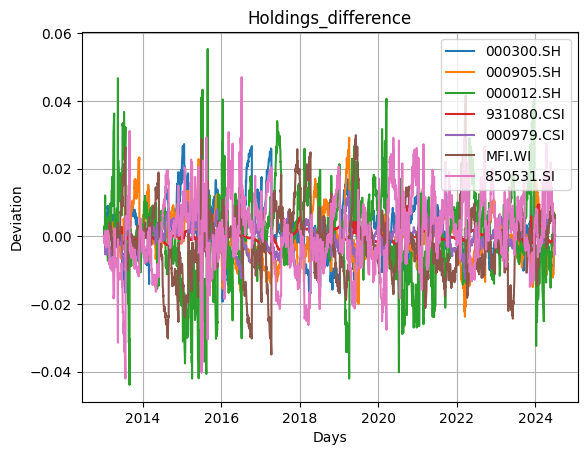

In [15]:
#偏离图
trade_date = pd.to_datetime(trade_date, format='%Y%m%d')
plt.plot(trade_date,holdings_diffs,label=stocks)
plt.title('Holdings_difference')
plt.xlabel('Days')
plt.ylabel('Deviation')
plt.grid(True)
plt.legend()
plt.show()

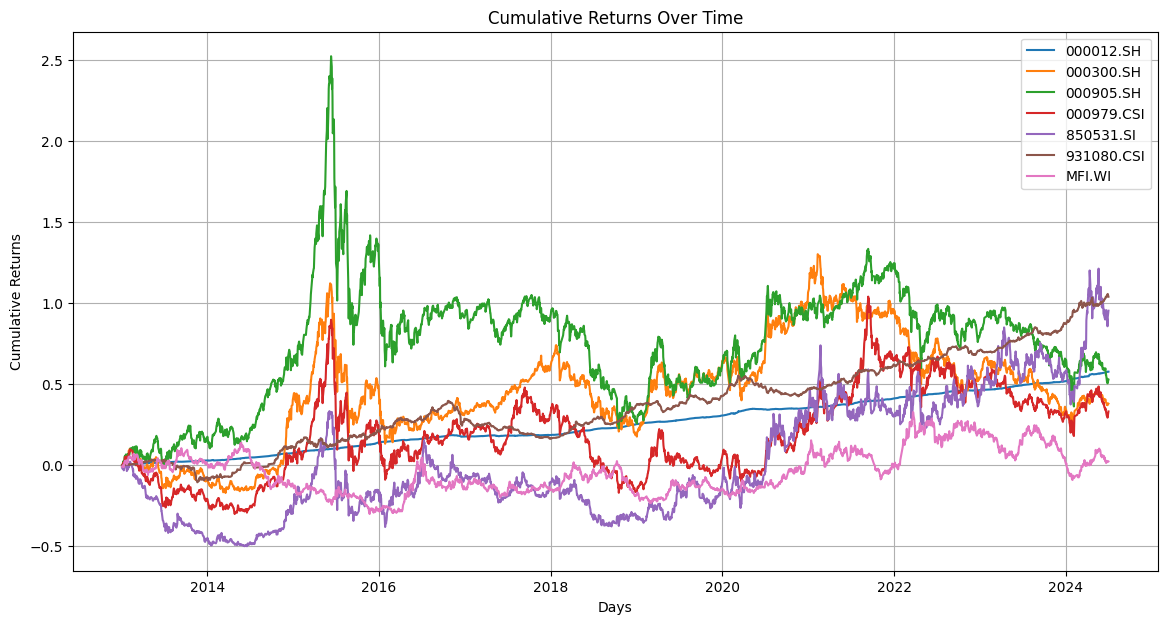

In [16]:
data =pd.read_csv('ret_df.csv')
plot_etf_returns(data,test_dt)

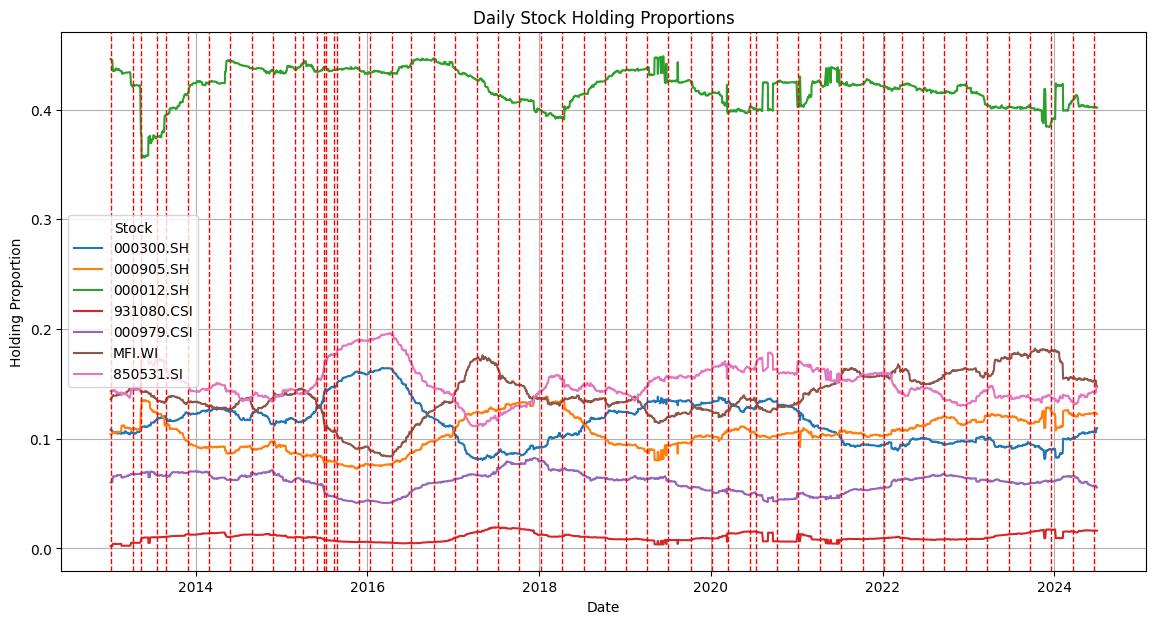

In [17]:
#理想持仓占比 以及换仓日
plt.figure(figsize=(14, 7))
for stock, weights in four_quarters.items():
    plt.plot(trade_date, weights, label=stock)
plt.legend(title='Stock')
for change_date in position_change:
    change_date = pd.to_datetime(change_date, format = '%Y%m%d')
    plt.axvline(change_date, color='red', linestyle='--', linewidth=1)
# 添加标题和轴标签
plt.title('Daily Stock Holding Proportions')
plt.xlabel('Date')
plt.ylabel('Holding Proportion')
plt.grid(True)

plt.savefig('stock_holdings_proportions_5.png', format='png', dpi=300)
# 显示图表
plt.show()

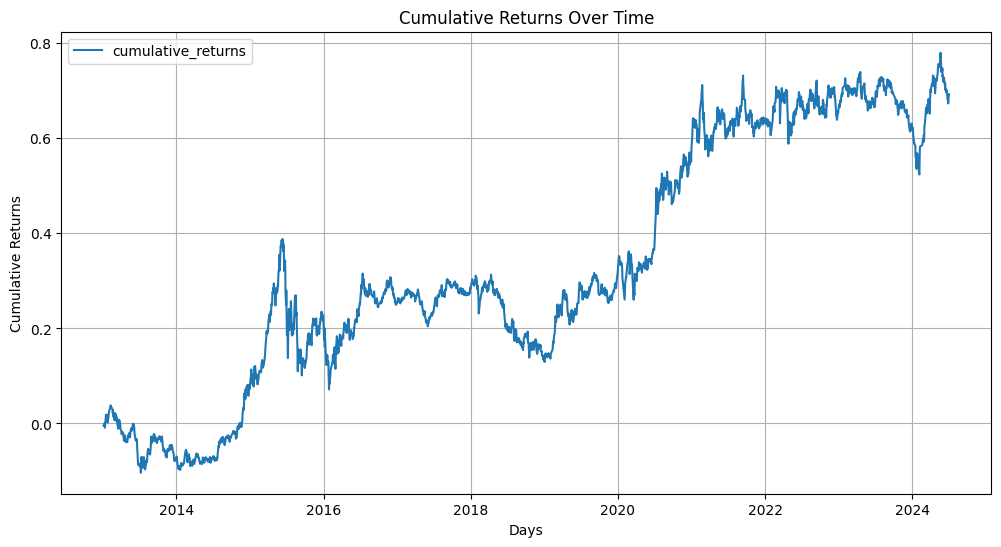

In [18]:
# portfolio年化收益
plot_cumulative_returns(daily_returns,trade_date)

In [19]:
#指标计算
win_rate, sharpe_ratio, max_drawdown = calculate_performance_metrics(daily_returns)
print(f"Win Rate: {win_rate}")
print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"Max Drawdown: {max_drawdown}")

Win Rate: 0.5229390681003584
Sharpe Ratio: 0.4938227391616086
Max Drawdown: 0.3164621945905206


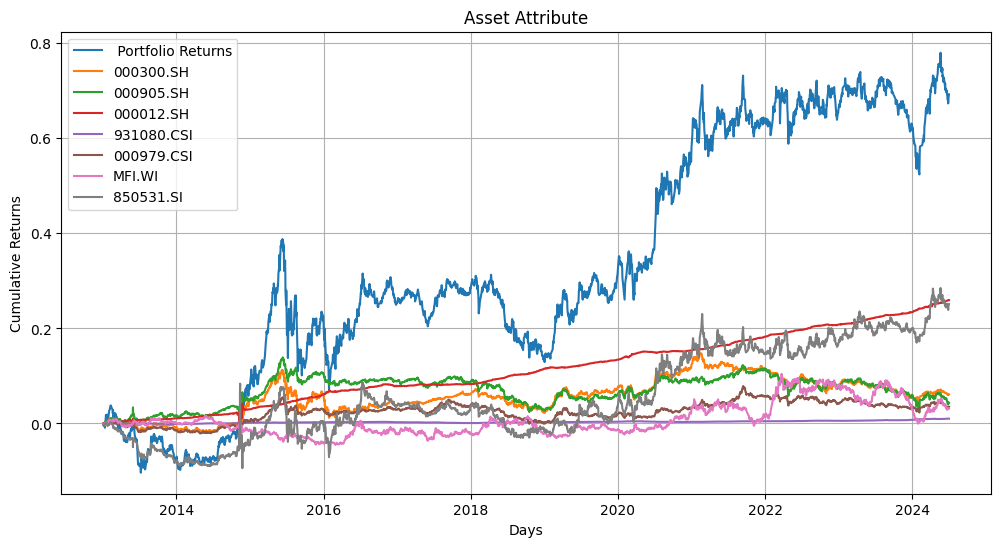

In [20]:
# 各资产收益贡献占比
cal_asset(daily_returns,stock_earnings,stock_list,trade_date)

In [21]:
section_earnings = {section:[] for section in results.keys()}
stock_weights_sum= {}
for section,weights in results.items():
     for stock,weight in weights.items():
        weight = np.array(weight)
        if stock not in stock_weights_sum.keys():
             stock_weights_sum[stock] = weight
        else:
            stock_weights_sum[stock] += weight

In [22]:
import math
def cal_smart_beta(daily_returns,stock_earnings,stock_list,trade_date,stock_weights_sum,results):
    #获得净值时间序列
    cumulative_returns = (1 + pd.Series(daily_returns)).cumprod() - 1
    stock_values = {stock:[] for stock in stock_list}
    for stock_earning in stock_earnings:
        for i,stock in enumerate(stock_list):
            stock_values[stock].append(stock_earning[i])

    section_values = {}
    section_name = ['高通胀','高增长','低增长','低通胀']
    for i,weights in enumerate(results.values()):
        for stock,weight in weights.items():
            print(stock)
            value = np.array(weight)/stock_weights_sum[stock]* np.array(stock_values[stock])
            if section_name[i] not in section_values.keys():
                section_values[section_name[i]] = value
            else:
                section_values[section_name[i]] += value
    
    total_value = sum(section_values.values())
    
    

    plt.figure(figsize=(12, 6))
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.plot(trade_date, cumulative_returns, label="Cumulative Returns")
    
   
    
    section_cum = []
    
    for section_name,value in section_values.items():
        section_series = value / total_value * cumulative_returns
        print(list(section_series)[-1])
        section_cum.append(section_series) 
        section_series = section_series.clip(lower=-0.5, upper=2.5)
        if section_name == '低通胀':
            rolling_window = 360
            target_returns = section_series 
            target_returns_series = pd.Series(target_returns)
            rolling_std = target_returns_series.rolling(window=rolling_window).std()*3


            upper_band = target_returns + rolling_std
            lower_band = target_returns - rolling_std
    

            #plt.plot(trade_date, upper_band, label='Upper Standard Deviation', linestyle='--')
            #plt.plot(trade_date, lower_band, label='Lower Standard Deviation', linestyle='--')
            plt.plot(trade_date, section_series, label=section_name)
        else:
            plt.plot(trade_date, section_series, label=section_name)   
        
    
    
    section_cum.append(cumulative_returns)    
    plt.title('Section Attribute')
    plt.xlabel('Days')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)
    plt.show()
    return section_cum

000979.CSI
MFI.WI
850531.SI
000300.SH
000905.SH
MFI.WI
000979.CSI
850531.SI
931080.CSI
000012.SH
000300.SH
000905.SH
931080.CSI
000012.SH
0.24448091012581744
0.100263848980756
0.19705561809790934
0.15078068679183854


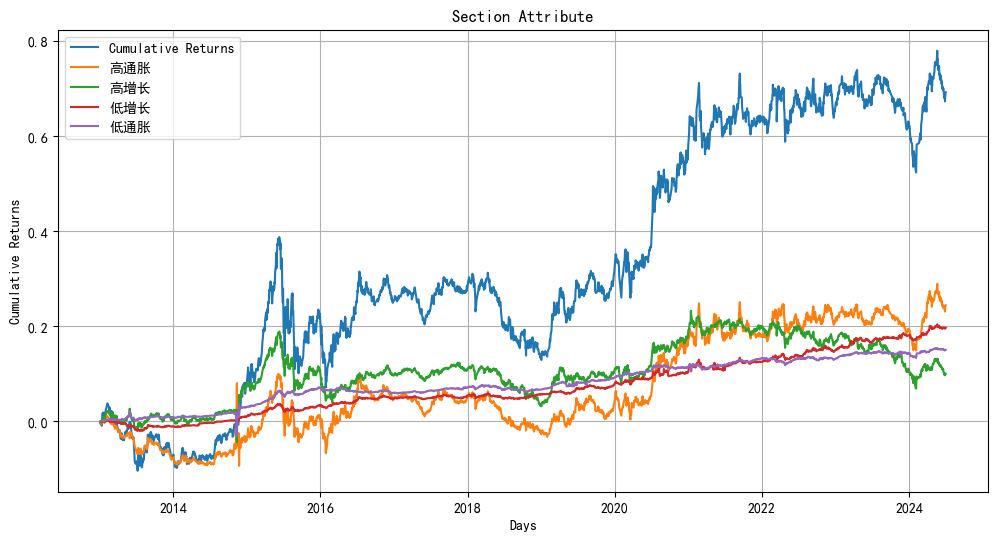

In [23]:
 # 各环境收益贡献占比
section_cum = cal_smart_beta(daily_returns,stock_earnings,stock_list,trade_date,stock_weights_sum,results)

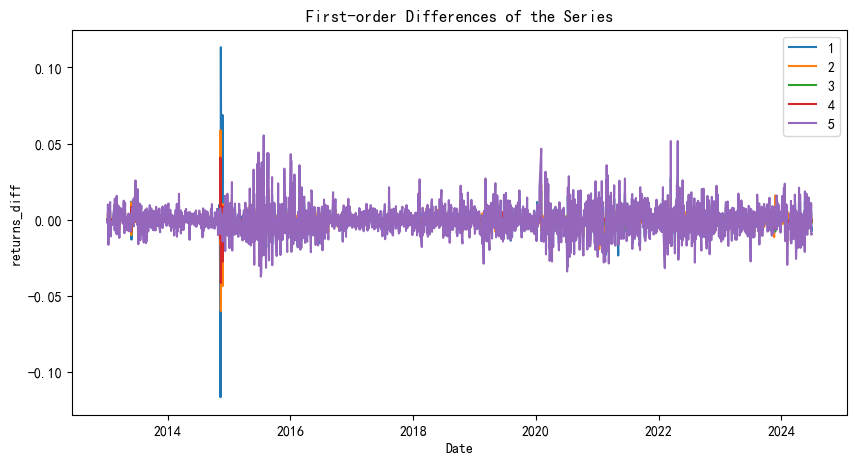

In [24]:
def diff_plot(section_cum,trade_date):   
    plt.figure(figsize=(10, 5))
    differences = []
    for i,section_value in enumerate(section_cum):
        difference = section_value - section_value.shift(-1)
        differences.append(difference)
    # 绘制一阶差分图
        plt.plot(trade_date[1:],difference.dropna(), label= i+1)

        # 添加图例
        plt.legend()

        # 添加标题和轴标签
        plt.title('First-order Differences of the Series')
        plt.xlabel('Date')
        plt.ylabel('returns_diff')

        # 显示图形
    plt.show()
    return differences
differences = diff_plot(section_cum,trade_date)

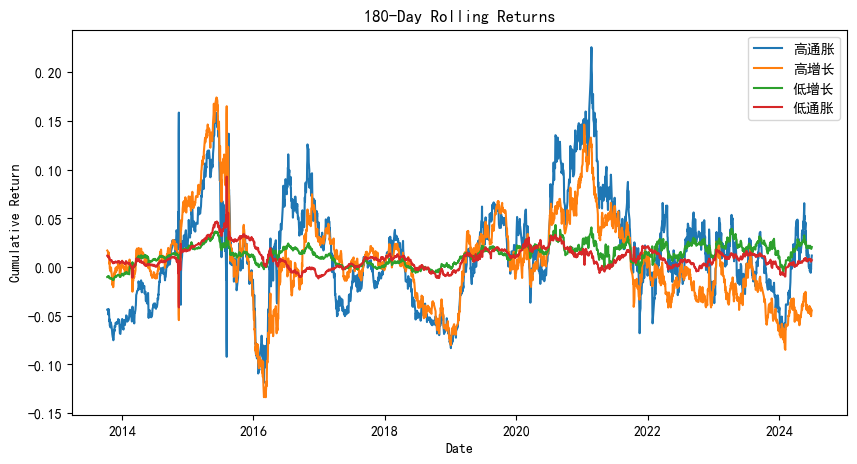

In [25]:
def window_env(section_cum, trade_date, window=180):
    plt.figure(figsize=(10, 5))
    plt.rcParams['font.sans-serif'] = ['SimHei']  
    plt.rcParams['axes.unicode_minus'] = False
    
    section_name = ['高通胀','高增长','低增长','低通胀']
    
    for i, section_value in enumerate(section_cum):
        difference = section_value - section_value.shift(1)
        difference = difference.dropna()
        
        cumulative_returns = []
        
        for j in range(len(difference) - window + 1):
            cumulative_return = (1 + pd.Series(difference[j:j + window])).cumprod().iloc[-1] - 1
            cumulative_returns.append(cumulative_return)
        
        aligned_dates = trade_date[window:len(cumulative_returns) + window]
        cumulative_returns = np.clip(cumulative_returns,-0.5, 2.5)
        plt.plot(aligned_dates, cumulative_returns, label= section_name[i])
    
    plt.legend()

    plt.title(f'{window}-Day Rolling Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    
    plt.show()
    
window_env(section_cum[:-1], trade_date)

<Figure size 1000x800 with 0 Axes>

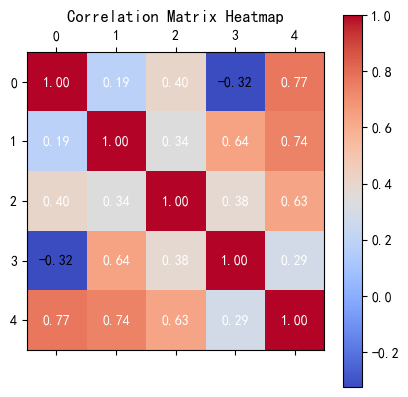

In [26]:
def corr_plot(differences):
    df = pd.DataFrame(differences).T
    corr_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    cax = plt.matshow(corr_matrix, cmap='coolwarm')
    plt.colorbar(cax)
    for (i, j), value in np.ndenumerate(corr_matrix):
        plt.text(j, i, f"{value:.2f}", ha="center", va="center", color="white" if value > 0 else "black")
    plt.title('Correlation Matrix Heatmap')
    plt.show()
corr_plot(differences)